In [2]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cluster import KMeans
from datetime import datetime, timedelta, date
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [3]:
# Read the data
customer = pd.read_csv('customer_segmentation.csv')
customer.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Feature Engineering

In [6]:
# Convert the InvoiceDate to datetime
customer['InvoiceDate'] = pd.to_datetime(customer['InvoiceDate'])

In [7]:
# Create YearMonth field for the ease of reporting and visualization
customer['InvoiceYearMonth'] = customer['InvoiceDate'].map(lambda date: 100*date.year + date.month)
customer.describe()

,index,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceYearMonth
count,541909.000000,541909.000000,541909,541909.000000,406829.000000,541909.000000
mean,270954.000000,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,201099.713989
min,0.000000,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,201012.000000
25%,135477.000000,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,201103.000000
50%,270954.000000,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,201107.000000
75%,406431.000000,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,201110.000000
max,541908.000000,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,201112.000000
std,156435.797851,218.081158,NaN,96.759853,1713.600303,25.788703


In [8]:
# Check the contents of the "Country" column
customer["Country"].value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


In [14]:
# Use only Australia data
customer_aus = customer[customer["Country"] == "Australia"].reset_index(drop=True)
customer_aus.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,197,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6,2010-12-01 10:03:00,8.50,12431.0,Australia,201012
1,198,536389,21622,VINTAGE UNION JACK CUSHION COVER,8,2010-12-01 10:03:00,4.95,12431.0,Australia,201012
2,199,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12,2010-12-01 10:03:00,1.25,12431.0,Australia,201012
3,200,536389,35004C,SET OF 3 COLOURED FLYING DUCKS,6,2010-12-01 10:03:00,5.45,12431.0,Australia,201012
4,201,536389,35004G,SET OF 3 GOLD FLYING DUCKS,4,2010-12-01 10:03:00,6.35,12431.0,Australia,201012


# Segmentation Techniques

Implement the RFM (Recency - Frequency - Monetary Value) Technique
1. Low Value - Less active customers
2. Mid Value - Fairly active customers
3. High Value - Most Active customers

## 1. Recency - The fact of being recent, of having occurred a relatively short time ago.
- Calculated by finding the most recent purchase date of each customer and find out the number of active days.
- K-means clusturing is applied to find the recency score

In [15]:
# Create a dataframe to keep customerID and new segmentation scores
customer_segmentation = customer_aus[['CustomerID']].drop_duplicates()
customer_segmentation

,CustomerID
0,12431.0
14,12386.0
22,12434.0
35,12415.0
84,12393.0
106,12388.0
125,12422.0
138,16321.0
642,12424.0


In [16]:
# Find out the last time the customer made a purchase
last_purchase = customer_aus.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase.columns = ['CustomerID', 'LastPurchaseDate']
last_purchase.head()

,CustomerID,LastPurchaseDate
0,12386.0,2011-01-06 12:37:00
1,12388.0,2011-11-24 12:30:00
2,12393.0,2011-09-28 15:41:00
3,12415.0,2011-11-15 14:22:00
4,12422.0,2011-09-05 09:48:00


In [17]:
# Calculate recency
last_purchase['Recency'] = (last_purchase['LastPurchaseDate'].max() - last_purchase['LastPurchaseDate']).dt.days
last_purchase.head()

,CustomerID,LastPurchaseDate,Recency
0,12386.0,2011-01-06 12:37:00,321
1,12388.0,2011-11-24 12:30:00,0
2,12393.0,2011-09-28 15:41:00,56
3,12415.0,2011-11-15 14:22:00,8
4,12422.0,2011-09-05 09:48:00,80


In [18]:
# Merge the dataframes
customer_segmentation = pd.merge(customer_segmentation, last_purchase[['CustomerID', 'Recency']], on='CustomerID')
customer_segmentation.head()

,CustomerID,Recency
0,12431.0,20
1,12386.0,321
2,12434.0,68
3,12415.0,8
4,12393.0,56


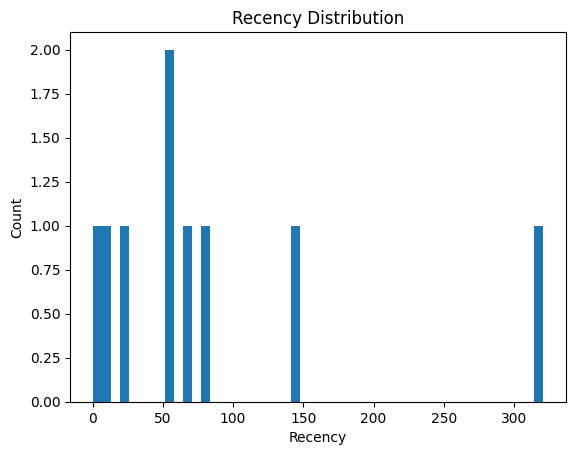

In [19]:
# Check the distribution of Recency
plt.hist(customer_segmentation['Recency'], bins=50)
plt.xlabel('Recency')
plt.ylabel('Count')
plt.title('Recency Distribution')
plt.show()